# Encoding of space: Co-homology and circular coordinates

- Install note: be sure you have cebra, and the demo dependencies, installed to use this notebook: 

In [ ]:
!pip install 'cebra[datasets,demos]'

In [16]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.collections import LineCollection

import cebra.datasets
import cebra
from cebra import CEBRA

- Be sure you have downloaded the data and placed `/data` from [FigShare](https://figshare.com/s/60adb075234c2cc51fa3) and into the `demo_notebooks` directory. Let's check if it's there:

In [1]:
ls

Demo_Allen.ipynb                      Demo_learnable_temperature.ipynb
Demo_cohomology.ipynb                 Demo_primate_reaching.ipynb
Demo_consistency.ipynb                Demo_primate_reaching_mse_loss.ipynb
Demo_conv-pivae.ipynb                 Demo_synthetic_exp.ipynb
Demo_decoding.ipynb                   README.rst
Demo_hippocampus.ipynb                data/
Demo_hippocampus_multisession.ipynb   rat_demo_example_output.h5
Demo_hypothesis_testing.ipynb


In [2]:
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

## Persistent cohomology analysis with CEBRA embeddings of varying output dimensions

**------------------- BEGINNING OF TRAINING SECTION -------------------**

### Train CEBRA-Behavior with different dimensions: 3, 8, 16

In [3]:
max_iterations = 10000 #default is 5000.

In [4]:
cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_posdir8_model= CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=8,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_posdir16_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=16,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [5]:
cebra_posdir3_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_posdir3_model.save("cebra_posdir3_model.pt")

cebra_posdir8_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_posdir8_model.save("cebra_posdir8_model.pt")

cebra_posdir16_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_posdir16_model.save("cebra_posdir16_model.pt")

pos:  0.1023 neg:  5.4131 total:  5.5155 temperature:  1.0000: 100%|██████████| 10000/10000 [02:32<00:00, 65.75it/s]
pos:  0.1074 neg:  5.3878 total:  5.4952 temperature:  1.0000: 100%|██████████| 10000/10000 [02:33<00:00, 65.12it/s]
pos:  0.1003 neg:  5.3875 total:  5.4878 temperature:  1.0000: 100%|██████████| 10000/10000 [02:42<00:00, 61.61it/s]


### Load the models and compute the embeddings

In [3]:
cebra_posdir3_model = cebra.CEBRA.load("cebra_posdir3_model.pt")
cebra_posdir3 = cebra_posdir3_model.transform(hippocampus_pos.neural)

cebra_posdir8_model = cebra.CEBRA.load("cebra_posdir8_model.pt")
cebra_posdir8 = cebra_posdir8_model.transform(hippocampus_pos.neural)

cebra_posdir16_model = cebra.CEBRA.load("cebra_posdir16_model.pt")
cebra_posdir16 = cebra_posdir16_model.transform(hippocampus_pos.neural)

### Plotting the results


In [4]:
right = hippocampus_pos.continuous_index[:,1] == 1
left = hippocampus_pos.continuous_index[:,2] == 1

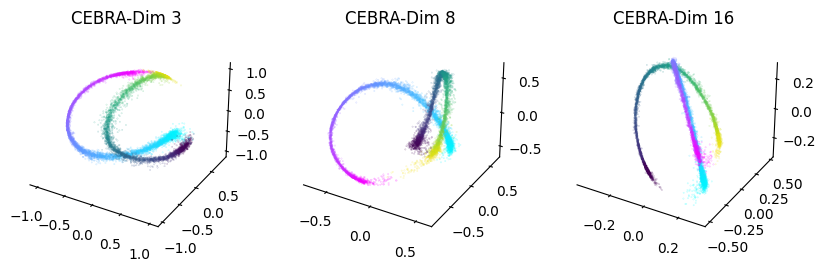

In [8]:
fig = plt.figure(figsize = (10,3), dpi = 100)

ax1 = plt.subplot(131,projection='3d')
ax2 = plt.subplot(132, projection = '3d')
ax3 = plt.subplot(133, projection = '3d')

for dir, cmap in zip([right, left], ["cool", "viridis"]):
    ax1 = cebra.plot_embedding(ax=ax1, embedding=cebra_posdir3[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], cmap=cmap)
    ax2 = cebra.plot_embedding(ax=ax2, embedding=cebra_posdir8[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], cmap=cmap)
    ax3 = cebra.plot_embedding(ax=ax3, embedding=cebra_posdir16[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], cmap=cmap)

ax1.set_title('CEBRA-Dim 3')
ax2.set_title('CEBRA-Dim 8')
ax3.set_title('CEBRA-Dim 16')
plt.show()

## Topological Data Analysis:

### Get random 1000 points of embeddings and do persistent cohomology analysis upto H1

- note this requires the ripser package.
- If you previously installed DREiMac (such as running this notebook before, there are some dependency clashes with ripser, so you need to uninstall it first, and reinstall risper:

In [ ]:
!pip uninstall -y dreimac
!pip uninstall -y cebra
!pip uninstall -y ripser

In [ ]:
!pip install ripser

#Depending on your system, this can cause errors.
#Thus if issues please follow these instructions directly: https://pypi.org/project/ripser/
import ripser

- if you get the error `ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 80 from PyObject`, please delete the folders from DREiMac and run the cell above again. 

In [ ]:
maxdim=1 ## Set to 2 to compute upto H2. The computing time is considerably longer. For quick demo upto H1, set it to 1.
np.random.seed(111)
random_idx=np.random.permutation(np.arange(len(cebra_posdir3)))[:1000]
topology_dimension = {}
for embedding in [cebra_posdir3, cebra_posdir8, cebra_posdir16]:
    ripser_output=ripser.ripser(embedding[random_idx], maxdim=maxdim, coeff=47)
    dimension = embedding.shape[1]
    topology_dimension[dimension] = ripser_output

### If you want to visualize the pre-computed persistent co-homology result:

- preloading saves quite a bit of time; to adapt to your own datasets please set topology_dimension and random_inx.

In [ ]:
preload=pd.read_hdf(os.path.join(CURRENT_DIR,'rat_demo_example_output.h5'))
topology_dimension = preload['topology']
topology_random_dimension = preload['topology_random']
random_idx = preload['embedding']['random_idx']
maxdim=2

In [ ]:
def plot_barcode(topology_result, maxdim):
    fig, axs = plt.subplots(maxdim+1, 1, sharex=True, figsize=(7, 8))
    axs[0].set_xlim(0,2)
    cocycle = ["Points", "Loops", "Voids"]
    for k in range(maxdim+1):
        bars = topology_result['dgms'][k]
        bars[bars == np.inf] = 10
        lc = (
            np.vstack(
                [
                    bars[:, 0],
                    np.arange(len(bars), dtype=int) * 6,
                    bars[:, 1],
                    np.arange(len(bars), dtype=int) * 6,
                ]
            )
            .swapaxes(1, 0)
            .reshape(-1, 2, 2)
        )
        line_segments = LineCollection(lc, linewidth=5, color="gray", alpha=0.5)
        axs[k].set_ylabel(cocycle[k], fontsize=20)
        if k == 0:
            axs[k].set_ylim(len(bars) * 6 - 120, len(bars) * 6)
        elif k == 1:
            axs[k].set_ylim(0, len(bars) * 1 - 30)
        elif k == 2:
            axs[k].set_ylim(0, len(bars) * 6 + 10)
        axs[k].add_collection(line_segments)
        axs[k].set_yticks([])
        if k == 2:
            axs[k].set_xticks(np.linspace(0, 2, 3), np
                              .linspace(0, 2, 3), fontsize=15)
            axs[k].set_xlabel("Lifespan", fontsize=20)
    
    return fig 

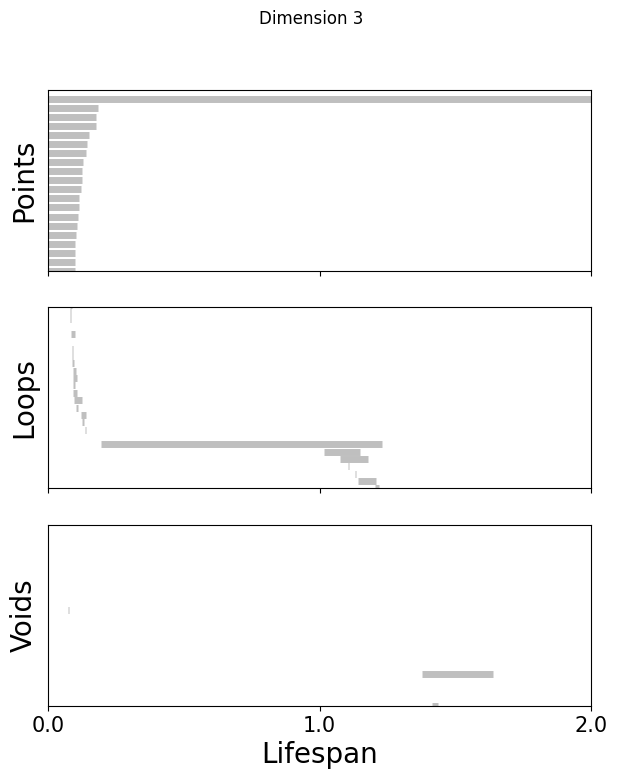

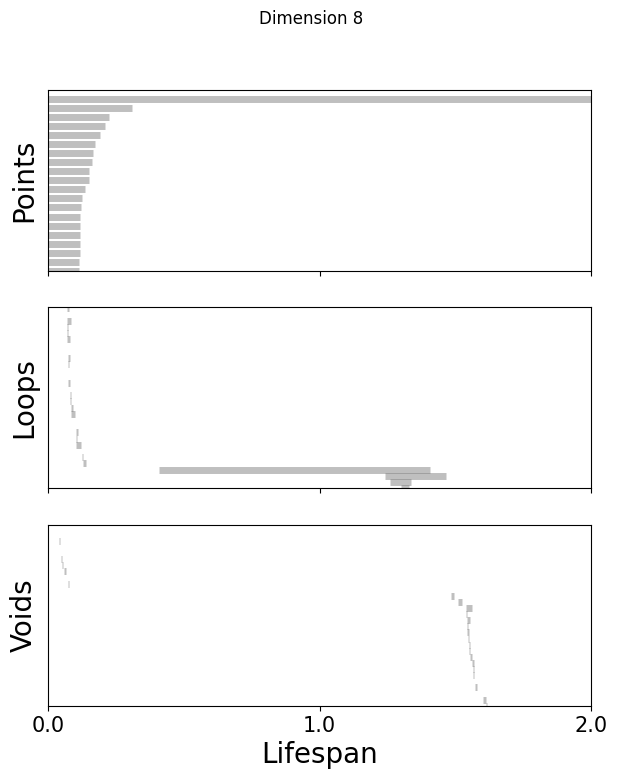

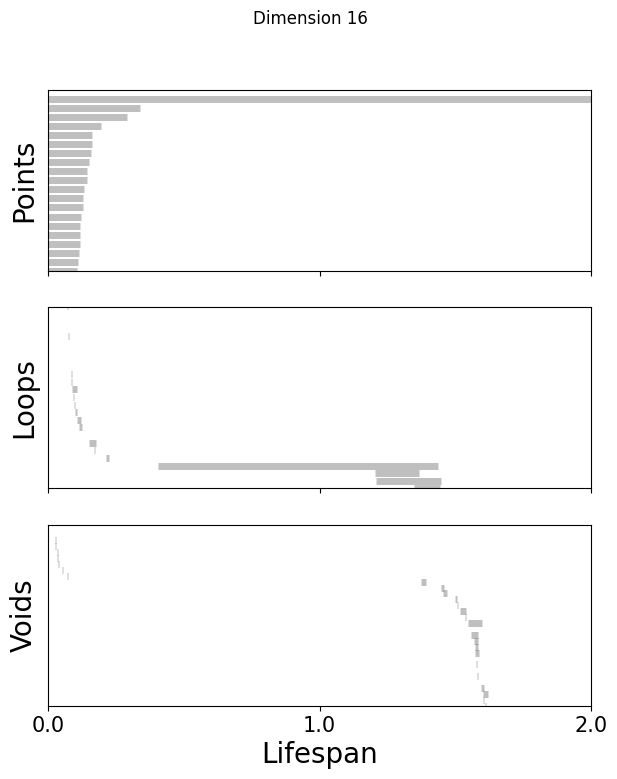

In [ ]:
%matplotlib inline
for k in [3,8,16]:
    fig=plot_barcode(topology_dimension[k], maxdim)
    fig.suptitle(f'Dimension {k}')

In [ ]:
from persim import plot_diagrams

def read_lifespan(ripser_output, dim):
    dim_diff = ripser_output['dgms'][dim][:, 1] - ripser_output['dgms'][dim][:, 0]
    if dim == 0:
        return dim_diff[~np.isinf(dim_diff)]
    else:
        return dim_diff

def get_max_lifespan(ripser_output_list, maxdim):
    lifespan_dic = {i: [] for i in range(maxdim+1)}
    for f in ripser_output_list:
        for dim in range(maxdim+1):
            lifespan = read_lifespan(f, dim)
            lifespan_dic[dim].extend(lifespan)
    return [max(lifespan_dic[i]) for i in range(maxdim+1)], lifespan_dic

def get_betti_number(ripser_output, shuffled_max_lifespan):
    bettis=[]
    for dim in range(len(ripser_output['dgms'])):
        lifespans=ripser_output['dgms'][dim][:, 1] - ripser_output['dgms'][dim][:, 0]
        betti_d = sum(lifespans > shuffled_max_lifespan[dim] * 1.1)
        bettis.append(betti_d)
    return bettis
def plot_lifespan(topology_dgms, shuffled_max_lifespan, ax, label_vis, maxdim):
    plot_diagrams(
        topology_dgms,
        ax=ax,
        legend=True,
    )

    ax.plot(
        [
            -0.5,
            2,
        ],
        [-0.5 + shuffled_max_lifespan[0], 2 + shuffled_max_lifespan[0]],
        color="C0",
        linewidth=3,
        alpha=0.5,

    )
    ax.plot(
        [
            -0.5,
            2,
        ],
        [-0.5 + shuffled_max_lifespan[1], 2 + shuffled_max_lifespan[1]],
        color="orange",
        linewidth=3,
        alpha=0.5,

    )
    if maxdim == 2:
        ax.plot(
            [-0.50, 2],
            [-0.5 + shuffled_max_lifespan[2], 2 + shuffled_max_lifespan[2]],
            color="green",
            linewidth=3,
            alpha=0.5,
        )
    ax.set_xlabel("Birth", fontsize=15)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels([0, 1, 2])
    ax.tick_params(labelsize=13)
    if label_vis:
        ax.set_ylabel("Death", fontsize=15)
    else:
        ax.set_ylabel("")



Betti No. for dimension 3: [1, 1, 0]
Betti No. for dimension 8: [1, 1, 0]
Betti No. for dimension 16: [1, 1, 0]


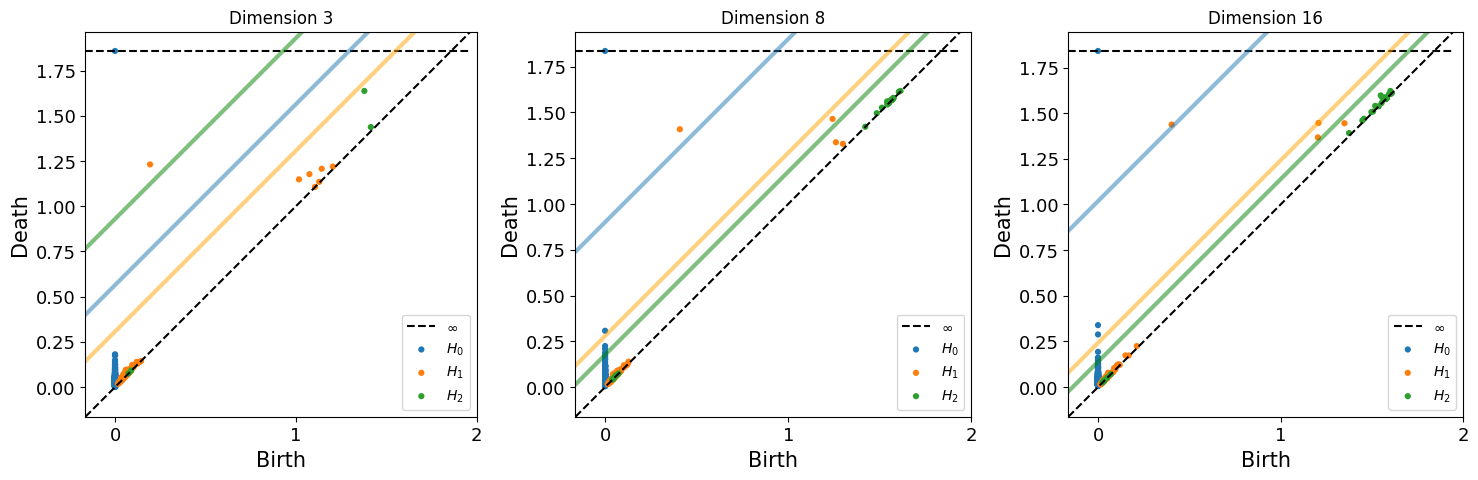

In [ ]:
fig = plt.figure(figsize=(18,5))
for n, dim in enumerate([3,8,16]):
    shuffled_max_lifespan, lifespan_dic = get_max_lifespan(topology_random_dimension[dim], maxdim)
    ax = fig.add_subplot(1,3,n+1)
    ax.set_title(f'Dimension {dim}')
    plot_lifespan(topology_dimension[dim]['dgms'], shuffled_max_lifespan, ax, True, maxdim)
    print(f"Betti No. for dimension {dim}: {get_betti_number(topology_dimension[dim], shuffled_max_lifespan)}")

### Visualize topology-preserving circular coordinates from the first co-cycle.

- This requires the DREiMac codebase. Here, we show you how to install their package:

In [ ]:
!pip install git+https://github.com/ctralie/DREiMac.git@cdd6d02ba53c3597a931db9da478fd198d6ed00f

In [21]:
from dreimac import CircularCoords

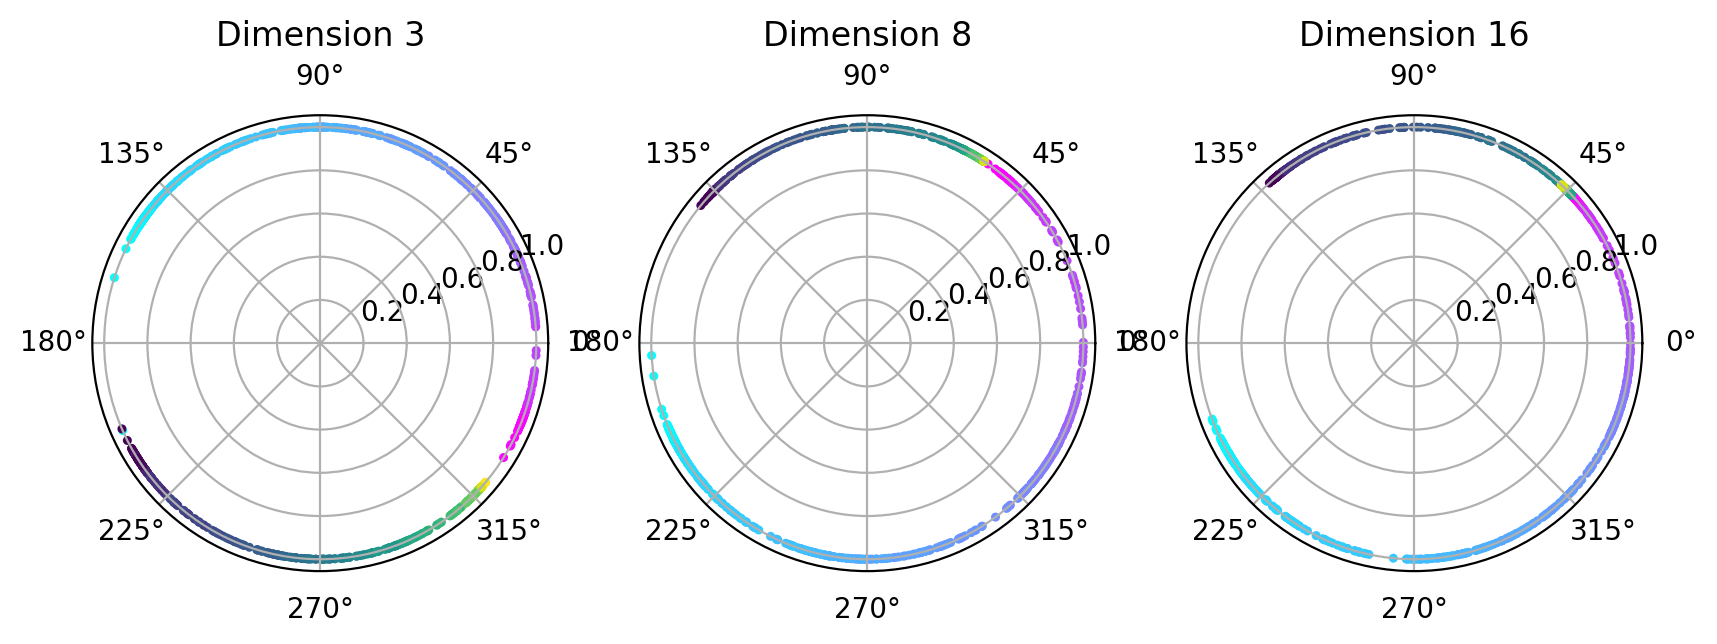

In [22]:
%matplotlib inline

prime = 47
dimension = [3,8,16]
fig, axs = plt.subplots(1, 3, figsize=(10,3), dpi=200, subplot_kw={'projection': 'polar'})
label = hippocampus_pos.continuous_index[random_idx]
r_ind = label[:,1]==1
l_ind = label[:,2]==1
for i, embedding in enumerate([cebra_posdir3, cebra_posdir8, cebra_posdir16]):
    rat_emb=embedding[random_idx]
    cc = CircularCoords(rat_emb, 1000, prime = prime, )
    radial_angle=cc.get_coordinates(cocycle_idx=[0])
    r = np.ones(1000)
    right=axs[i].scatter(radial_angle[r_ind], r[r_ind], s=5, c = label[r_ind,0], cmap = 'cool')
    left=axs[i].scatter(radial_angle[l_ind], r[l_ind], s=5, c = label[l_ind,0], cmap = 'viridis')
    axs[i].set_title(f'Dimension {dimension[i]}')
plt.show()

### Visualize Polar coordinate (radial angle) vs. Position

###### if you want to preload our data, run the following, otherwise skip this cell:

In [23]:
cebra_pos3 = preload['embedding'][3]
cebra_pos8 = preload['embedding'][8]
cebra_pos16 = preload['embedding'][16]

In [24]:
radial_angles = {}
for i, embedding in enumerate([cebra_pos3, cebra_pos8, cebra_pos16]):
    rat_emb=embedding[random_idx]
    cc = CircularCoords(rat_emb, 1000, prime = prime, )
    out=cc.get_coordinates()
    radial_angles[dimension[i]] = out

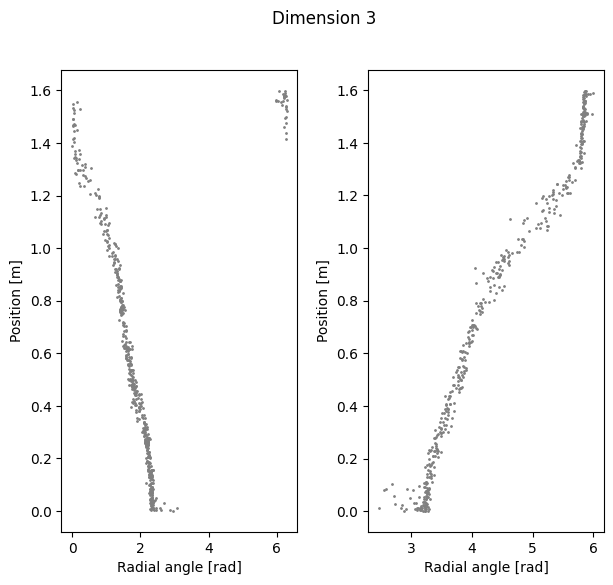

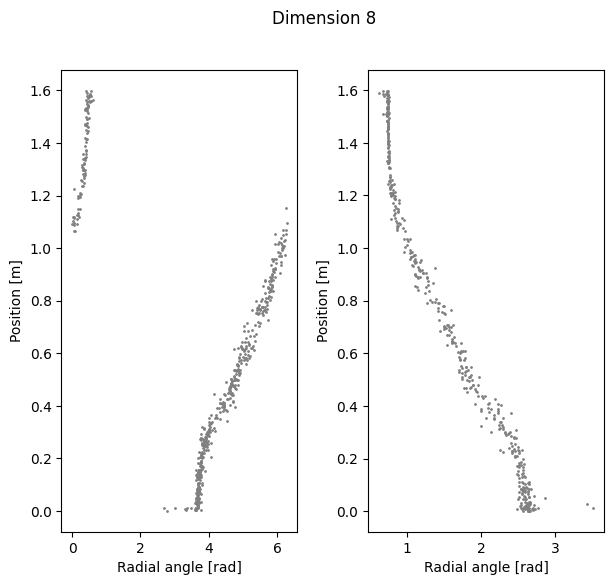

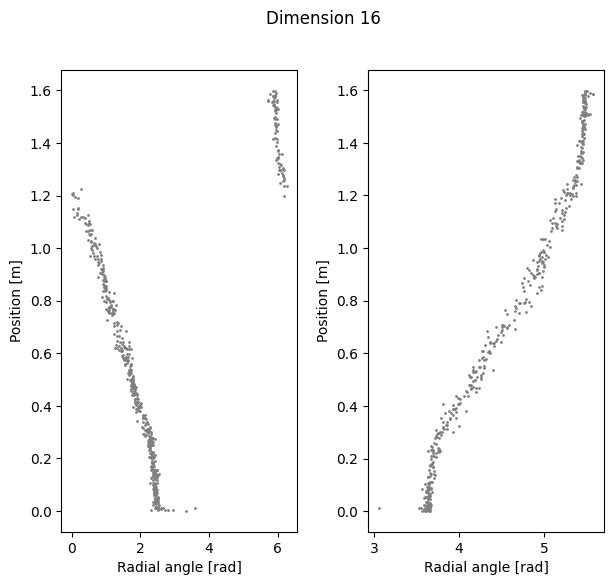

In [25]:
%matplotlib inline
for k in radial_angles.keys():
    fig=plt.figure(figsize=(7,6))
    plt.subplots_adjust(wspace=0.3)
    fig.suptitle(f'Dimension {k}')
    ax1=plt.subplot(121)
    ax1.scatter(radial_angles[k][r_ind], label[r_ind,0], s=1, c = 'gray')
    ax1.set_xlabel('Radial angle [rad]')
    ax1.set_ylabel('Position [m]')
    ax2=plt.subplot(122)
    ax2.scatter(radial_angles[k][l_ind], label[l_ind,0], s=1, c= 'gray')
    ax2.set_xlabel('Radial angle [rad]')
    ax2.set_ylabel('Position [m]')
plt.show()

### Compute linear correlation between computed coordinate and the position

In [26]:
import sklearn.linear_model
def lin_regression(radial_angles, labels):
    def _to_cartesian(radial_angles):
        x = np.cos(radial_angles)
        y = np.sin(radial_angles)
        return np.vstack([x,y]).T
    cartesian = _to_cartesian(radial_angles)
    lin = sklearn.linear_model.LinearRegression()
    lin.fit(cartesian, labels)
    
    return lin.score(cartesian, labels)

In [27]:
for k in radial_angles.keys():
    print(f'Dimension {k} Cycle angle into position')
    print(f'Right R2: {lin_regression(radial_angles[k][r_ind], label[r_ind,0])}')
    print(f'Left R2: {lin_regression(radial_angles[k][l_ind], label[l_ind,0])}')
    print(f'Total R2: {lin_regression(radial_angles[k], label[:,0])}')

Dimension 3 Cycle angle into position
Right R2: 0.9786339781977732
Left R2: 0.9636014502747399
Total R2: 0.9563695397160188
Dimension 8 Cycle angle into position
Right R2: 0.9288158799657967
Left R2: 0.9607563744350794
Total R2: 0.892921888751599
Dimension 16 Cycle angle into position
Right R2: 0.9614739746985121
Left R2: 0.9702177580250442
Total R2: 0.949558194067378


### Interactive plot to explore co-cycles and circular coordinates.
- Top left panel is a lifespan diagram of persistent co-homology analysis.
- Bottom left panel is a visualization of the first 2 dimensions of the used 1000 embedding points.
- Bottom right panel is a circular coordinate obtained from the co-cycles.
- For more information: https://github.com/ctralie/DREiMac

/home/celia/miniconda3/envs/cebra/lib/python3.10/site-packages/dreimac/emcoords.py:66: UserWarning: Could not accurately determine screen size
  warnings.warn("Could not accurately determine screen size")


<IPython.core.display.Javascript object>


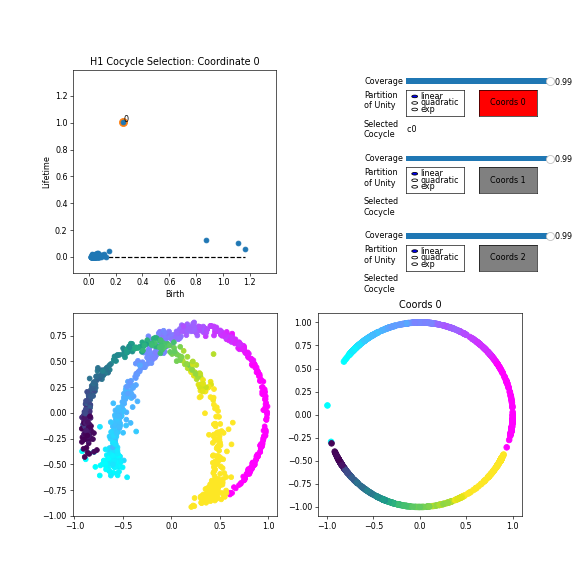

In [ ]:
## change the embedding to use. Here, we look at 3D embedding for posdir3 (position+dir, dim 3):
X=cebra_posdir3[random_idx] 

%matplotlib notebook
rl_stack=np.vstack([X[r_ind], X[l_ind]])
label_stack = np.vstack([label[r_ind], label[l_ind]])

c1 = plt.get_cmap('cool')
C1 = c1(label[r_ind,0])
c2 = plt.get_cmap('viridis')
C2 = c2(label[l_ind,0])

C = np.vstack([C1,C2])

def plot_circles(ax):
    ax.scatter(rl_stack[:, 0], rl_stack[:, 1], c=C)


cc = CircularCoords(rl_stack, 1000, prime = prime)
cc.plot_torii(C, coords_info=2, plots_in_one=3, lowerleft_plot=plot_circles)
